## mesa environment

https://mesa.readthedocs.io/latest/tutorials/intro_tutorial.html

In [1]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## mesa basics

In [2]:
class MoneyAgent(mesa.Agent):
    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

In [3]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, seed=42):
        super().__init__(seed=seed)
        self.num_agents = n
        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

In [4]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's attribute and set the initial values.
        self.wealth = 1

    def say_hi(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print(f"Hi, I am an agent, you can call me {self.unique_id!s}.")

class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, seed=42):
        super().__init__(seed=seed)
        self.num_agents = n

        # Create n agents
        MoneyAgent.create_agents(model=self, n=n)

    def step(self):
        """Advance the model by one step."""
        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        self.agents.do("say_hi")

In [5]:
starter_model = MoneyModel(10)
starter_model.step()

Hi, I am an agent, you can call me 1.
Hi, I am an agent, you can call me 2.
Hi, I am an agent, you can call me 3.
Hi, I am an agent, you can call me 4.
Hi, I am an agent, you can call me 5.
Hi, I am an agent, you can call me 6.
Hi, I am an agent, you can call me 7.
Hi, I am an agent, you can call me 8.
Hi, I am an agent, you can call me 9.
Hi, I am an agent, you can call me 10.


In [6]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

    def exchange(self):
        # Verify agent has some wealth
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.agents)
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

    def step(self):
        """Advance the model by one step."""
        # This function psuedo-randomly reorders the list of agent objects and
        # then iterates through calling the function passed in as the parameter
        self.agents.shuffle_do("exchange")

In [7]:
model = MoneyModel(10)  # Tells the model to create 10 agents
for _ in range(30):  # Runs the model for 30 steps;
    model.step()

# Note: An underscore is common convention for a variable that is not used.

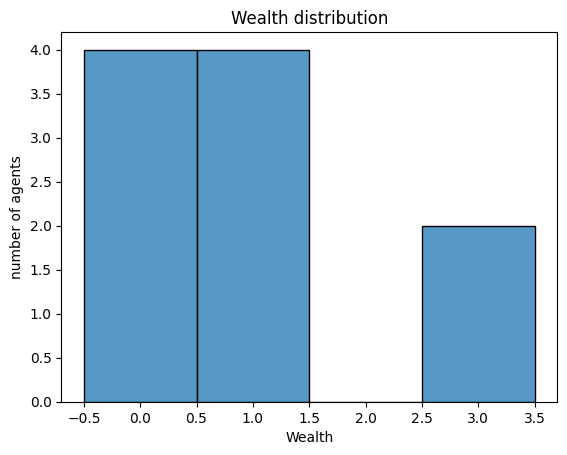

In [8]:
agent_wealth = [a.wealth for a in model.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="number of agents"
);  # The semicolon is just to avoid printing the object representation

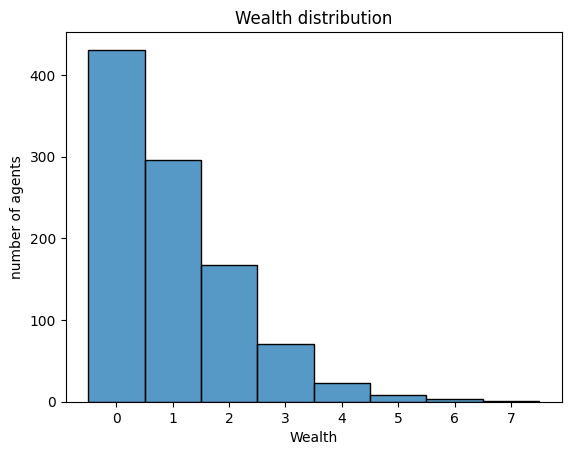

In [9]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for _ in range(100):
    # Run the model
    model = MoneyModel(10)
    for _ in range(30):
        model.step()

    # Store the results
    for agent in model.agents:
        all_wealth.append(agent.wealth)

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [10]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y coordinates for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [11]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

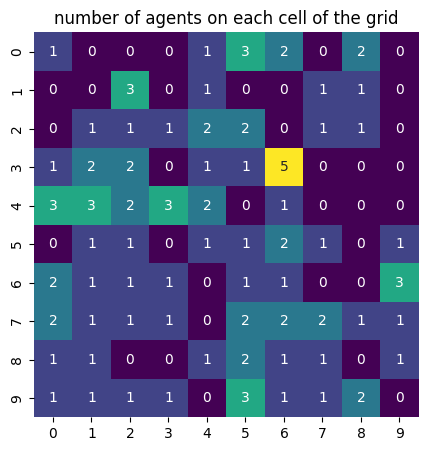

In [12]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="number of agents on each cell of the grid");

In [13]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        # Create the space
        self.grid = mesa.space.MultiGrid(width, height, True)
        # Collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [14]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()

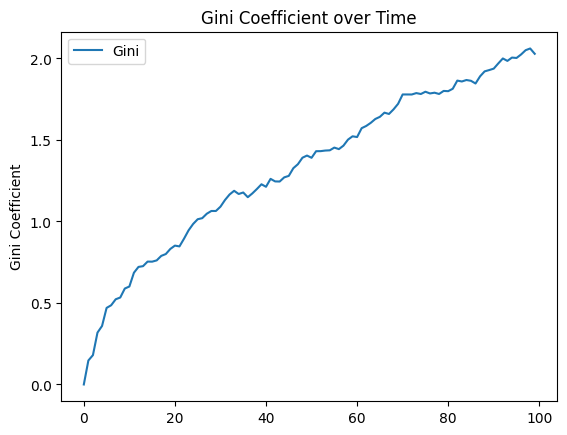

In [15]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [16]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
1    1             1
     2             1
     3             1
     4             1
     5             1

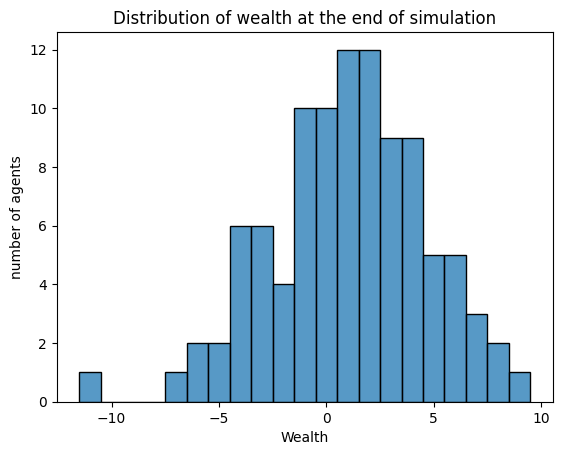

In [17]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="number of agents",
);

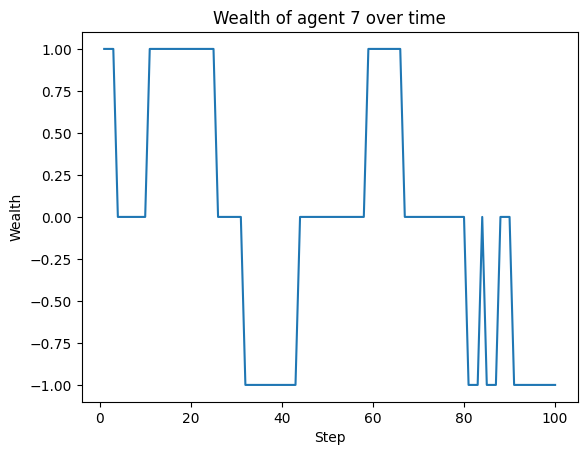

In [18]:
# Get the wealth of agent 7 over time
one_agent_wealth = agent_wealth.xs(7, level="AgentID")

# Plot the wealth of agent 7 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 7 over time");

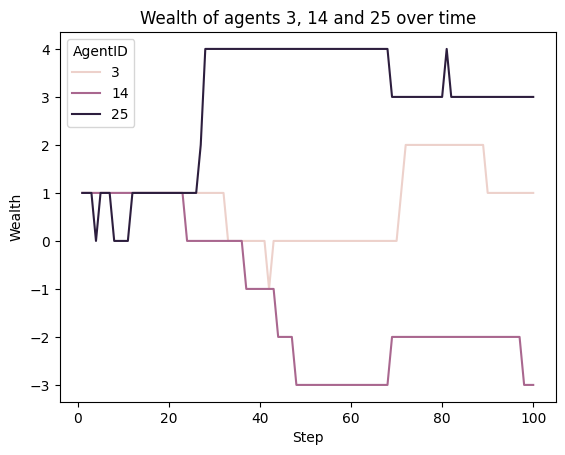

In [19]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

[Text(0.5, 1.0, 'Average wealth over time')]

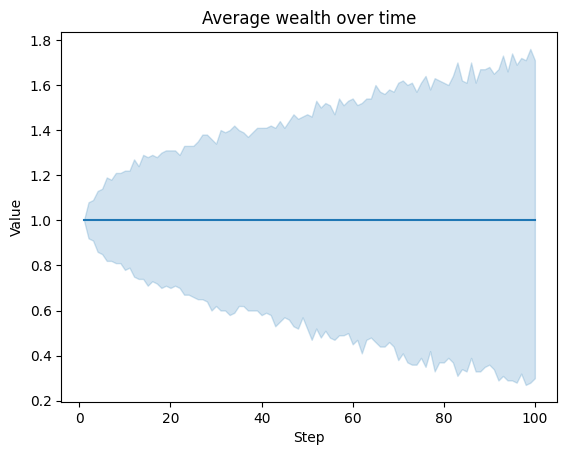

In [20]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

In [21]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

In [22]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def give_money(self, poor_agents):
        if self.wealth > 0:
            other_agent = self.random.choice(poor_agents)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        # Get lists of rich and poor agents
        rich_agents = model.agents.select(lambda a: a.wealth >= 3)
        poor_agents = model.agents.select(lambda a: a.wealth < 3)
        # When there is rich agents only have them give money to poor agents
        if len(rich_agents) > 0:
            rich_agents.shuffle_do("give_money", poor_agents)
        else:
            poor_agents.shuffle_do("give_money", poor_agents)

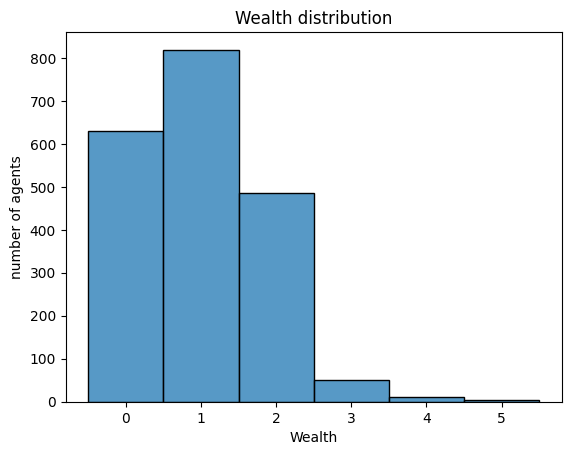

In [23]:
model = MoneyModel(100)
for _ in range(20):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [24]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, ethnicity):
        super().__init__(model)
        self.wealth = 1
        self.ethnicity = ethnicity

    def give_money(self, similars):
        if self.wealth > 0:
            other_agent = self.random.choice(similars)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create a list of our different ethnicities
        ethnicities = ["Green", "Blue", "Mixed"]

        # Create agents
        MoneyAgent.create_agents(
            model=self, n=n, ethnicity=self.random.choice(ethnicities)
        )

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Ethnicity": "ethnicity"},
        )

    def step(self):
        self.datacollector.collect(self)
        # groupby returns a dictionary of
        # key: ethnicity and value: list of agents with that ethnicity
        grouped_agents = model.agents.groupby("ethnicity")

        for ethnic, similars in grouped_agents:
            if ethnic != "Mixed":
                similars.shuffle_do("give_money", similars)
            else:
                similars.shuffle_do(
                    "give_money", self.agents
                )  # This allows mixed to trade with anyone

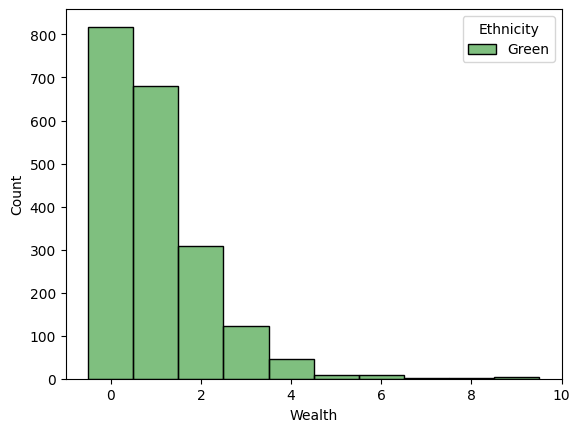

In [25]:
# Run the model
model = MoneyModel(100)
for _ in range(20):
    model.step()

# get the data
data = model.datacollector.get_agent_vars_dataframe()
# assign histogram colors
palette = {"Green": "green", "Blue": "blue", "Mixed": "purple"}
sns.histplot(data=data, x="Wealth", hue="Ethnicity", discrete=True, palette=palette)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [26]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.running = True

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("give_money")


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0 and self.wealth > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

In [27]:
params = {"width": 10, "height": 10, "n": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 95/95 [00:01<00:00, 59.36it/s]


In [28]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID',
       'Wealth', 'Steps_not_given'],
      dtype='object')


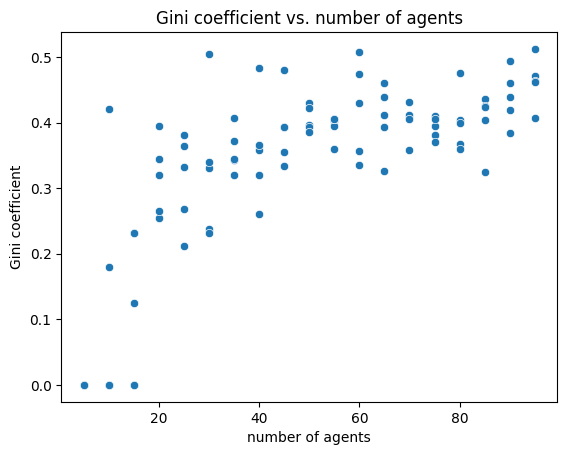

In [29]:
# Filter the results to only contain the data of one agent
# The Gini coefficient will be the same for the entire population at any time
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step == 100)]
results_filtered[["iteration", "n", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="n", y="Gini")
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

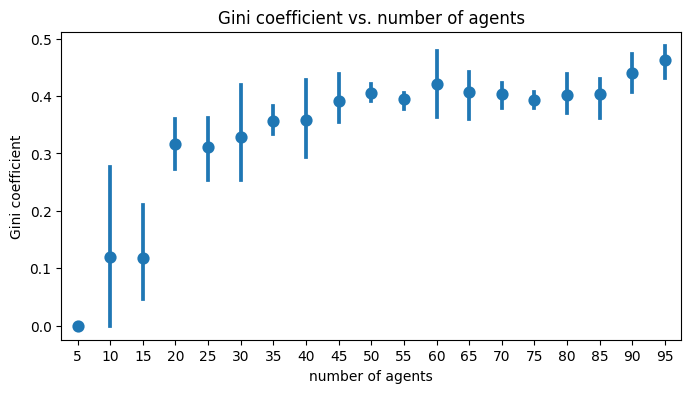

In [30]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="n", y="Gini", linestyle="None")
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

In [31]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.n == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)
# For a prettier display we can also convert the data frame to html
# Uncomment the two lines below to test in Jupyter
from IPython.display import display, HTML
display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0      NaN     NaN
    1      1.0     1.0
    1      2.0     1.0
    1      3.0     1.0
    1      4.0     1.0
  ...      ...     ...
  100      6.0     0.0
  100      7.0     1.0
  100      8.0     1.0
  100      9.0     2.0
  100     10.0     1.0


Step,AgentID,Wealth
0,NaN,NaN
1,1.0,1.0
1,2.0,1.0
1,3.0,1.0
1,4.0,1.0
1,5.0,1.0
1,6.0,1.0
1,7.0,1.0
1,8.0,1.0
1,9.0,1.0


In [32]:
results_one_episode = results_df[
    (results_df.n == 10) & (results_df.iteration == 1) & (results_df.AgentID == 1)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))

 Step  Gini
    1   0.0
    2   0.0
    3   0.0
    4   0.0
    5   0.0
  ...   ...
   96   0.0
   97   0.0
   98   0.0
   99   0.0
  100   0.0


In [33]:
params = {"seed": None, "width": 10, "height": 10, "n": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=25,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Need to collect every step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

100%|██████████| 125/125 [00:01<00:00, 88.78it/s]


In [34]:
# Again filter the results to only contain the data of one agent
# The Gini coefficient will be the same for the entire population at any time.
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 1)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,seed,width,height,n,Gini,AgentID,Wealth,Steps_not_given
1,0,0,1,None,10,10,5,0.0,1.0,1.0,0.0
6,0,0,2,None,10,10,5,0.0,1.0,1.0,1.0
11,0,0,3,None,10,10,5,0.0,1.0,1.0,2.0


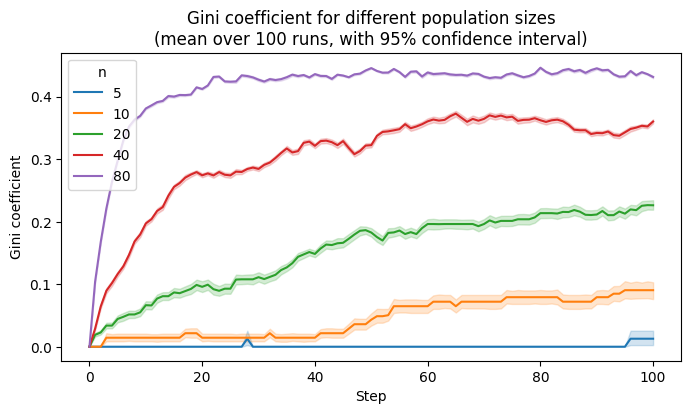

In [35]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="n",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = (
    "Gini coefficient for different population sizes\n"
    "(mean over 100 runs, with 95% confidence interval)"
)
g.set(title=plot_title, ylabel="Gini coefficient");

In [36]:
# Calculate the mean of the wealth and the number of consecutive rounds
# for all agents in each episode.
agg_results_df = (
    results_5s_df.groupby(["iteration", "n", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,n,Step,Wealth,Steps_not_given
0,0,5,0,NaN,NaN
1,0,5,1,1.0,0.0
2,0,5,2,1.0,1.0


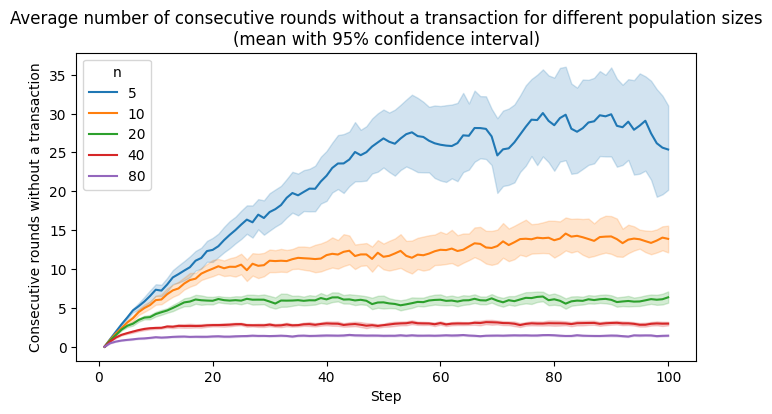

In [37]:
# Create a line plot with error bars
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="n", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for "
    "different population sizes\n(mean with 95% confidence interval)",
    ylabel="Consecutive rounds without a transaction",
);

## Visualization tutorial

In [1]:
import mesa
from mesa.visualization import SolaraViz, make_plot_component, make_space_component

print(f"Mesa version: {mesa.__version__}")


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        """initialize a MoneyAgent instance.

        Args:
            model: A model instance
        """
        super().__init__(model)
        self.wealth = 1

    def move(self):
        """move to a random neighboring cell."""
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        """give money to another agent in the same gridcell."""
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        """do one step of the agent."""
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n=10, width=10, height=10, seed=None):
        """Initialize a MoneyModel instance.

        Args:
            N: The number of agents.
            width: width of the grid.
            height: Height of the grid.
        """
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)

    def step(self):
        """do one step of the model"""
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

Mesa version: 3.1.4


### part 1

In [5]:
def agent_portrayal(agent):
    return {
        "color": "tab:blue",
        "size": 50,
    }

In [6]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

In [7]:
# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)  # keyword arguments

SpaceGraph = make_space_component(agent_portrayal)
GiniPlot = make_plot_component("Gini")

page = SolaraViz(
    money_model,
    components=[SpaceGraph, GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)
# This is required to render the visualization in the Jupyter notebook
page

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cannot show ipywidgets in text

### part 2 dynamic agent representation

In [2]:
def agent_portrayal(agent):
    size = 10
    color = "tab:red"
    if agent.wealth > 0:
        size = 50
        color = "tab:blue"
    return {"size": size, "color": color}


model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

In [3]:
# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)

SpaceGraph = make_space_component(agent_portrayal)
GiniPlot = make_plot_component("Gini")

page = SolaraViz(
    money_model,
    components=[SpaceGraph, GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text

### part 3 custom components

In [2]:
import solara
from matplotlib.figure import Figure

from mesa.visualization.utils import update_counter

In [3]:
def agent_portrayal(agent):
    size = 10
    color = "tab:red"
    if agent.wealth > 0:
        size = 50
        color = "tab:blue"
    return {"size": size, "color": color}


model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

In [4]:
@solara.component
def Histogram(model):
    update_counter.get()  # This is required to update the counter
    # Note: you must initialize a figure using this method instead of
    # plt.figure(), for thread safety purpose
    fig = Figure()
    ax = fig.subplots()
    wealth_vals = [agent.wealth for agent in model.agents]
    # Note: you have to use Matplotlib's OOP API instead of plt.hist
    # because plt.hist is not thread-safe.
    ax.hist(wealth_vals, bins=10)
    solara.FigureMatplotlib(fig)



In [5]:
# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)

SpaceGraph = make_space_component(agent_portrayal)
GiniPlot = make_plot_component("Gini")

In [6]:
page = SolaraViz(
    money_model,
    components=[SpaceGraph, GiniPlot, Histogram],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text

In [7]:
Histogram(money_model)

Cannot show ipywidgets in text

## best practices tutorial
--> https://mesa.readthedocs.io/latest/best-practices.html